In [166]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

## Task 1
We load the forest covertype dataset into a pandas dataframe.

In [167]:
df = pd.read_csv("covtype.csv", sep=',')

## Task 2
We then plot the class distribution of the target variable 'Cover_Type' in the form of a histogram. The plot tells us that the distribution is highly skewed in favor of two of the seven classes (imbalanced). As we have less data for the remaining five classes we should expect to see lower prediction accuracy for these. 

c:\Users\aujo8\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 251'. Pick better value with 'binwidth'.


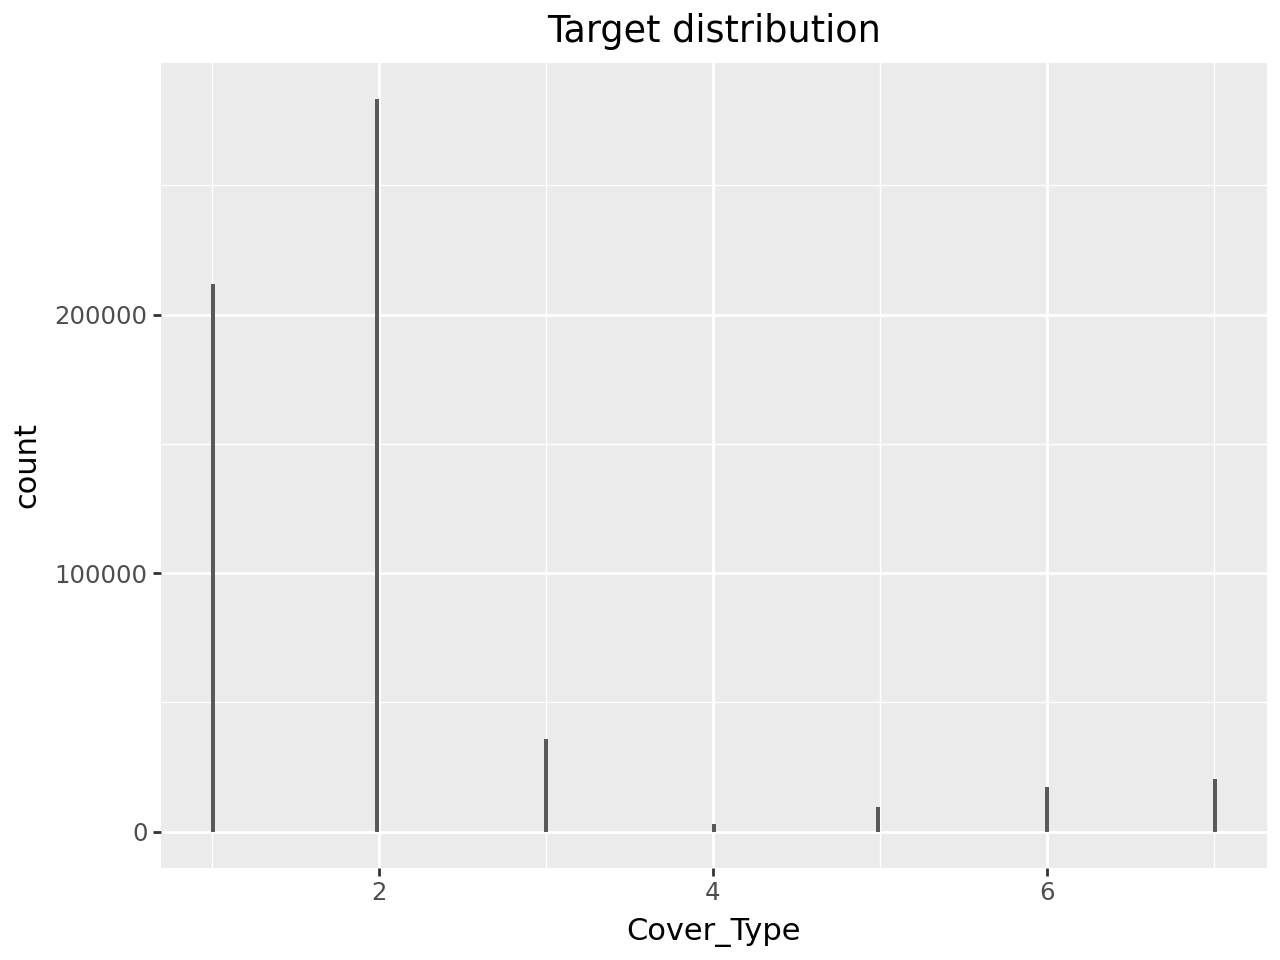

In [168]:
ggplot(df, aes(x="Cover_Type")) +\
    geom_histogram() +\
    ggtitle("Target distribution")

## Task 3
Below we have created a function that standardizes the columns of whatever data it is given. As will become evident from the following tasks we don't actually perform the standardization just yet.

In [169]:
def standardize(data):
    m = np.mean(data, axis=0)
    s = np.std(data, axis=0)
    strd_data = (data - m)/s
    return strd_data

## Task 4
Improves stability.

The standardization should take place **after** the split into training, validation and test data. This is because the mean and standard deviation might no longer be entirely representative for the subsets of data if they are calculated using the whole dataset. In our case, it probably doesn't make a lot of difference, due to the large sizes of even the subsets, but in order to follow good practice, we split the data first.

## Task 5

In [ ]:
train, testval = train_test_split(df, test_size=0.2, random_state=19970128)
test, val = train_test_split(testval, test_size=0.5, random_state=19970128)

In [ ]:
# standardizing the non-categorical features (the first ten features)
# also seperating the data into targets y and input features X
X_train = pd.concat([standardize(train.iloc[:, 0:10]), train.iloc[:, 10:-1]], axis=1)
# y_train = train["Cover_Type"]
y_train = pd.get_dummies(train["Cover_Type"], dtype=int)

X_test = pd.concat([standardize(test.iloc[:, 0:10]), test.iloc[:, 10:-1]], axis=1)
# y_test = test["Cover_Type"]
y_test = pd.get_dummies(test["Cover_Type"], dtype=int)

X_val = pd.concat([standardize(val.iloc[:, 0:10]), val.iloc[:, 10:-1]], axis=1)
# y_val = val["Cover_Type"]
y_val = pd.get_dummies(val["Cover_Type"], dtype=int)

## Task 6

In [172]:
import os
import torch
from torch.utils.data import DataLoader
from torch import nn

# if possible, running on GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "hip"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [173]:
# transforming our data into tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

X_test_tensor = torch.tensor(X_test.values).float() 
y_test_tensor = torch.tensor(y_test.values).float()

X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).float()

In [174]:
# creating torch datasets in preparation for mini batches
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

# the dataloaders for the mini batches
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [176]:
# defining the neural net
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 60),
            nn.ReLU(),
            nn.Linear(60, 65),
            nn.ReLU(),
            nn.Linear(65, 70),
            nn.ReLU(),
            nn.Linear(70, 65),
            nn.ReLU(),
            nn.Linear(65, 60),
            nn.ReLU(),
            nn.Linear(60, 7),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
# instantiating the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=54, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=65, bias=True)
    (3): ReLU()
    (4): Linear(in_features=65, out_features=70, bias=True)
    (5): ReLU()
    (6): Linear(in_features=70, out_features=65, bias=True)
    (7): ReLU()
    (8): Linear(in_features=65, out_features=60, bias=True)
    (9): ReLU()
    (10): Linear(in_features=60, out_features=7, bias=True)
  )
)


In [177]:
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# per epoch losses
training_loss = []
validation_loss = []

# training/validation loop
for epoch in range(epochs):
    
    # training phase
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (X, y) in enumerate(train_dl):
        b = batch
        # Move data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dl)
    training_loss.append(avg_train_loss)
    print(f"Average training Loss: {avg_train_loss:.4f}")

    # validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dl)
    validation_loss.append(avg_val_loss)
    print(f"Average validation Loss: {avg_val_loss:.4f}\n")


print("Training complete!")

Epoch 1
-------------------------------
Average training Loss: 0.5732
Average validation Loss: 0.4716

Epoch 2
-------------------------------
Average training Loss: 0.4355
Average validation Loss: 0.4129

Epoch 3
-------------------------------
Average training Loss: 0.3777
Average validation Loss: 0.3537

Epoch 4
-------------------------------
Average training Loss: 0.3438
Average validation Loss: 0.3299

Epoch 5
-------------------------------
Average training Loss: 0.3205
Average validation Loss: 0.3070

Epoch 6
-------------------------------
Average training Loss: 0.3019
Average validation Loss: 0.3063

Epoch 7
-------------------------------
Average training Loss: 0.2859
Average validation Loss: 0.2978

Epoch 8
-------------------------------
Average training Loss: 0.2726
Average validation Loss: 0.2891

Epoch 9
-------------------------------
Average training Loss: 0.2615
Average validation Loss: 0.2537

Epoch 10
-------------------------------
Average training Loss: 0.2515
Av

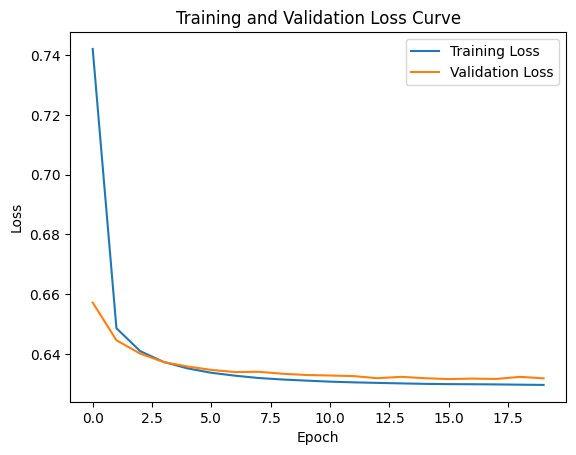

In [165]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.show()

Är det förskjutet ett steg till vänster i träning/validering-kurvan?
Rimlig slutsats utifrån traget distribution?